# Sea current time series decomposition

## 1. Libraries import

In [2]:
source('lib_import.R')
source('setup.R') 
library(gridExtra)
library(latex2exp)
library(timetk)
library(cowplot)

[1] "setting up ggplot theme and colours"


## 2. Data import

### 2.1. Velocity data

In [3]:
source('velocity_data_import.R')

df.v.merged$depth.raw <- df.v.merged$depth
df.v.merged$depth <- factor(paste0(df.v.merged$depth," [m]"),levels=c("7 [m]","10 [m]","15 [m]","25 [m]"),ordered=TRUE)


cn <- colnames(df.v.merged)
cn[match("point",cn)] <- "site"
colnames(df.v.merged) <- cn

[1] "reading velocities"
[1] "* * * * * * * Part 1 * * * * * * * *"
[1] "cleaning velocity dataframe"
[1] "* * * * * * * Part 2 * * * * * * * *"
[1] "removing imroper values form v2"
[1] "creating month-year factor for df.v and df.v2"
[1] "Finished creating df.v and df.v2 data frames."
[1] "Creatng merged data frame: df.v.merged"


`summarise()` has grouped output by 'point'. You can override using the
`.groups` argument.


### 2.2. Chemical and depth sensor data

In [4]:
source('chemical_data_import.R')

[1] "importing physical and chemical data"
[1] "* * * * * * * Part 1 * * * * * * * *"
[1] "* * * * * * * Part 2 * * * * * * * *"
[1] "creating month-year factor for df.all and df.all2"
[1] "Finished creating df.all and df.all2 data frames."
[1] "Creating merged dataframe df.merged"


`summarise()` has grouped output by 'point'. You can override using the
`.groups` argument.
Warning message in eval(ei, envir):
"Some features were updated in the first part of the dataset. Therefore check columns compatibility before analyses."


## 3. Velocity time series decomposition

In [5]:
roll.period.main.trend = 30
roll.period.seasonal.trend = 8

pts <- levels(df.v.merged$site)
dpths <- levels(df.v.merged$depth)

df.v.trends <- NULL

for (pt in pts){
    tmp.df.v.pt <- df.v.merged[df.v.merged$site==pt,] 
    for (dpt in dpths){
        tmp.df <- tmp.df.v.pt[tmp.df.v.pt$depth==dpt,] 
        if (nrow(tmp.df)>0){
            tmp.df <- tmp.df %>%  mutate(
                         velocityN.trend=slidify_vec(.x = velocityN,
                                                     .period = roll.period.main.trend,
                                                     .f=mean,na.rm   = TRUE,
                                                     .align  = "center"),
                         velocityE.trend=slidify_vec(.x = velocityE,
                                                     .period = roll.period.main.trend,
                                                     .f=mean,na.rm   = TRUE,
                                                     .align  = "center"))
  
            tmp.df <- tmp.df %>%  mutate(
                         velocityN.seasonal=slidify_vec(.x = velocityN,
                                                     .period = roll.period.seasonal.trend,
                                                     .f=mean,na.rm   = TRUE,
                                                     .align  = "center") - velocityN.trend,
                         velocityE.seasonal=slidify_vec(.x = velocityE,
                                                     .period = roll.period.seasonal.trend,
                                                     .f=mean,na.rm   = TRUE,
                                                     .align  = "center") - velocityE.trend)            

            tmp.df <- tmp.df %>%  mutate(
                         velocityN.random= velocityN - velocityN.trend - velocityN.seasonal,
                         velocityE.random= velocityE - velocityE.trend - velocityE.seasonal)             
            
            if (is.null(df.v.trends)){
                df.v.trends <- tmp.df
            } else {
                df.v.trends <- rbind(df.v.trends,tmp.df)
            }
        }
    }
}

head(df.v.trends)

,date_time,speed,heading,velocityN,velocityE,depth,site,kelp,m.yr.factor,w.yr.factor,depth.raw,velocityN.trend,velocityE.trend,velocityN.seasonal,velocityE.seasonal,velocityN.random,velocityE.random
,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<ord>,<fct>,<fct>,<ord>,<ord>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2021-08-13 00:00:00,1.89,180.44,-1.89,-0.01,7 [m],GF,FALSE,Aug21,W33-21,7,NA,NA,NA,NA,NA,NA
2,2021-08-13 00:05:00,1.64,177.22,-1.63,0.08,7 [m],GF,FALSE,Aug21,W33-21,7,NA,NA,NA,NA,NA,NA
3,2021-08-13 00:10:00,1.85,177.76,-1.85,0.07,7 [m],GF,FALSE,Aug21,W33-21,7,NA,NA,NA,NA,NA,NA
4,2021-08-13 00:15:00,1.88,179.00,-1.88,0.03,7 [m],GF,FALSE,Aug21,W33-21,7,NA,NA,NA,NA,NA,NA
5,2021-08-13 00:20:00,2.12,200.43,-1.99,-0.74,7 [m],GF,FALSE,Aug21,W33-21,7,NA,NA,NA,NA,NA,NA
6,2021-08-13 00:25:00,2.50,210.17,-2.16,-1.26,7 [m],GF,FALSE,Aug21,W33-21,7,NA,NA,NA,NA,NA,NA


In [6]:
colnames(df.v.trends)

[1] "date_time"          "speed"              "heading"           
 [4] "velocityN"          "velocityE"          "depth"             
 [7] "site"               "kelp"               "m.yr.factor"       
[10] "w.yr.factor"        "depth.raw"          "velocityN.trend"   
[13] "velocityE.trend"    "velocityN.seasonal" "velocityE.seasonal"
[16] "velocityN.random"   "velocityE.random"

## 4. Displaying a decomposed series

Set a week index to display decomposed time series

In [7]:
wks = sort(unique(df.v.merged$w.yr.factor)) # weeks vector
j <- 20

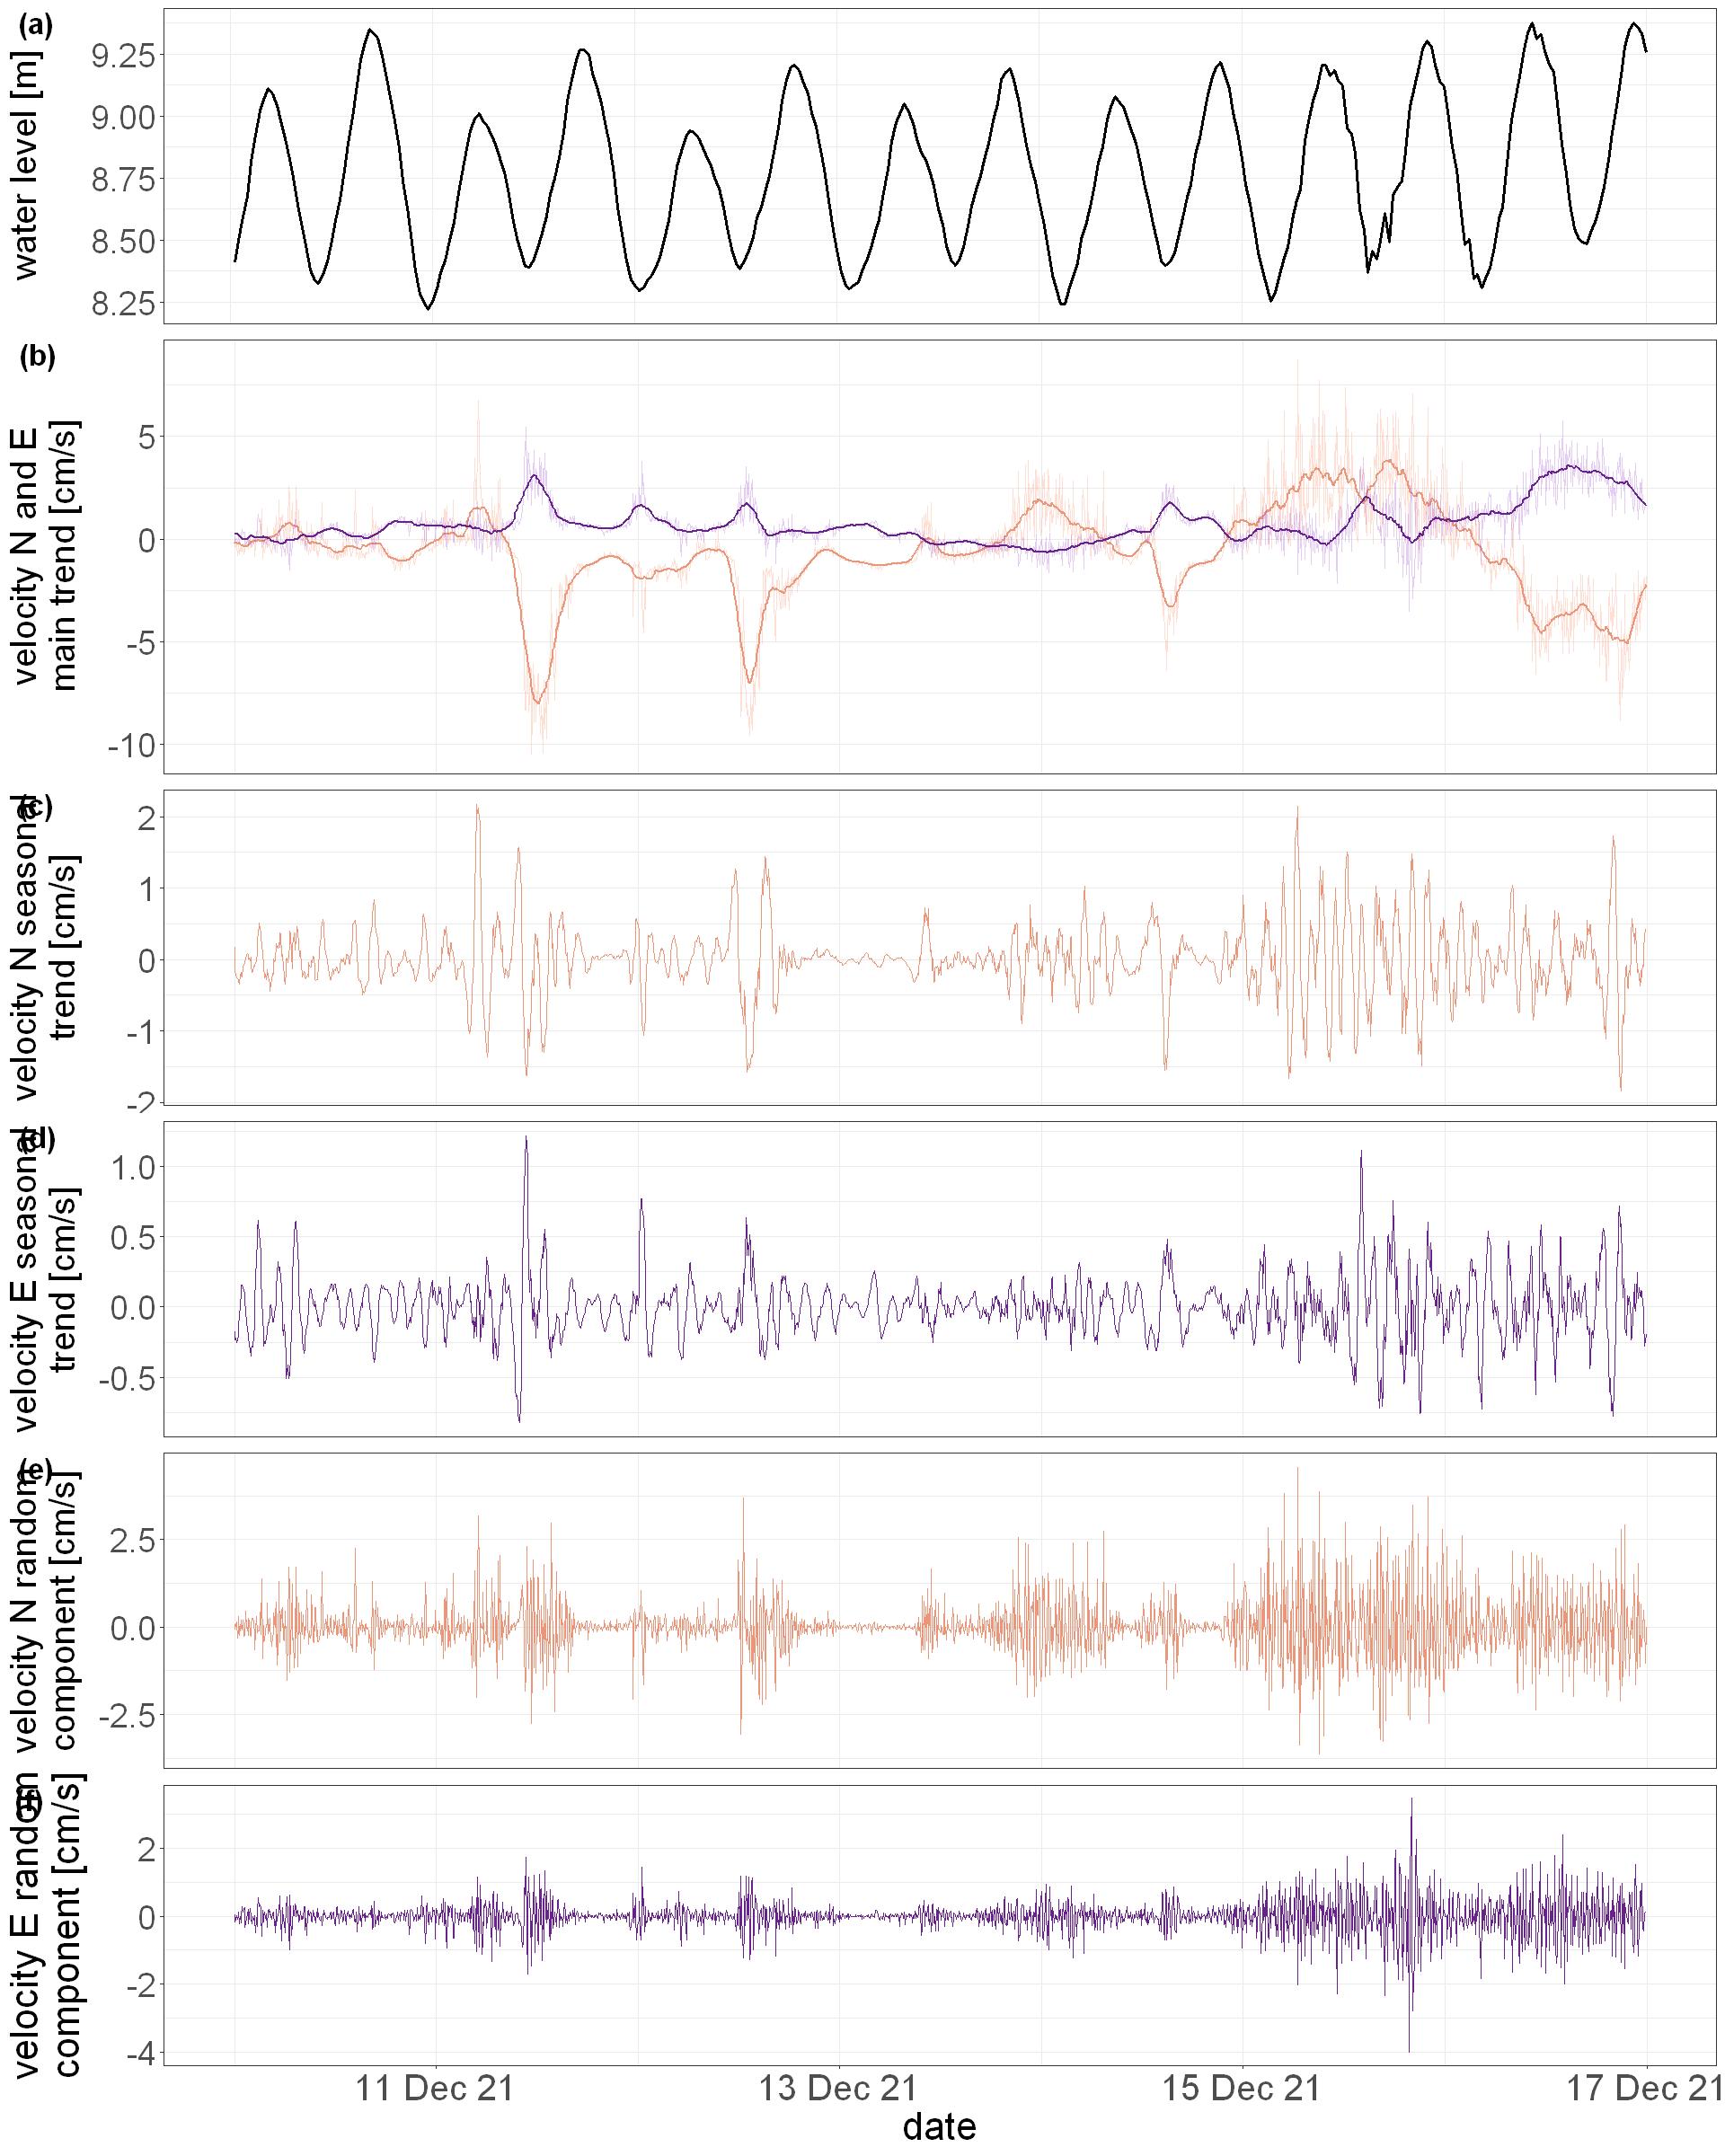

In [8]:
options(repr.plot.width=16, repr.plot.height=20)

wk <- wks[j] # week
pt <- pts[1] # point
dpt <- 7 # depth

# velocity N

tmp.df.v <- df.v.trends[df.v.trends$site==pt & df.v.trends$w.yr.factor==wk & df.v.trends$depth.raw==dpt,] 
tmp.df.all <- df.merged[df.merged$site==pt & df.merged$w.yr.factor==wk & df.merged$depth==dpt,] 


vel.trend.theme <- theme(  
                axis.title.y = element_text(size = 24),
                axis.text.y = element_text(size = 22),                  
                axis.title.x = element_blank(),
                axis.ticks.x = element_blank(),
                axis.text.x = element_blank(),            
                legend.position="none",
                plot.title = element_blank())


#options(repr.plot.width=20, repr.plot.height=6)
p1 <- ggplot(tmp.df.v,aes(x=date_time)) +
        geom_line(data=tmp.df.all,aes(x=date_time,y=sensor.depth),linewidth=1.0,color="black")+ # sensor depth
        ylab("water level [m]") +
vel.trend.theme
        

#options(repr.plot.width=20, repr.plot.height=8)
p2 <- ggplot(tmp.df.v,aes(x=date_time)) +
        geom_line(aes(y=velocityN),alpha=0.25,color="coral") + # all velocityN measurements
        geom_line(aes(y = velocityN.trend), color="darksalmon",linewidth=0.75) + # main velocityN trend
        geom_line(aes(y=velocityE),alpha=0.25,color="darkorchid") + # all velocityE measurements
        geom_line(aes(y=velocityE.trend), color="darkorchid4",linewidth=0.75)+ # main velocityE trend
        ylab("velocity N and E\nmain trend [cm/s]") +
vel.trend.theme

#options(repr.plot.width=20, repr.plot.height=6)
p3 <- ggplot(tmp.df.v ,aes(x=date_time)) +
        geom_line(aes(y = velocityN.seasonal), color="darksalmon",linewidth=0.5) + # seasonal velocityN trend
        ylab("velocity N seasonal\ntrend [cm/s]") +
vel.trend.theme 

#options(repr.plot.width=20, repr.plot.height=6)
p4 <- ggplot(tmp.df.v ,aes(x=date_time)) +
        geom_line(aes(y = velocityE.seasonal), color="darkorchid4",linewidth=0.5) + # seasonal velocityN trend
        ylab("velocity E seasonal\ntrend [cm/s]") +
vel.trend.theme 

#options(repr.plot.width=20, repr.plot.height=6)
p5 <- ggplot(tmp.df.v ,aes(x=date_time)) +
        geom_line(aes(y = velocityN.random), color="darksalmon",linewidth=0.5) + # seasonal velocityN trend
        ylab("velocity N random\ncomponent [cm/s]") +
vel.trend.theme 

p6 <- ggplot(tmp.df.v ,aes(x=date_time)) +
        geom_line(aes(y = velocityE.random), color="darkorchid4",linewidth=0.5) + # seasonal velocityN trend
        xlab("date") + ylab("velocity E random\ncomponent [cm/s]") +
        scale_x_datetime(date_labels = "%d %b %y") +
        theme(  axis.title.x = element_text(size = 26),
                axis.title.y = element_text(size = 26),
                axis.text.y = element_text(size = 22),   
                axis.text.x = element_text(size = 24),
                legend.position="none") 

cowplot::plot_grid(p1, p2, p3,p4,p5,p6, 
                        labels = c("(a)","(b)","(c)","(d)","(e)","(f)"), 
                        rel_heights = c(0.7, 0.95,0.7,0.7,0.7,0.8),
                        label_size = 20, align = "v", ncol = 1 )


## 5. Displaying trends

In [9]:
j <- 5
wks <- sort(unique(df.v.trends$w.yr.factor))
wk <- wks[j]

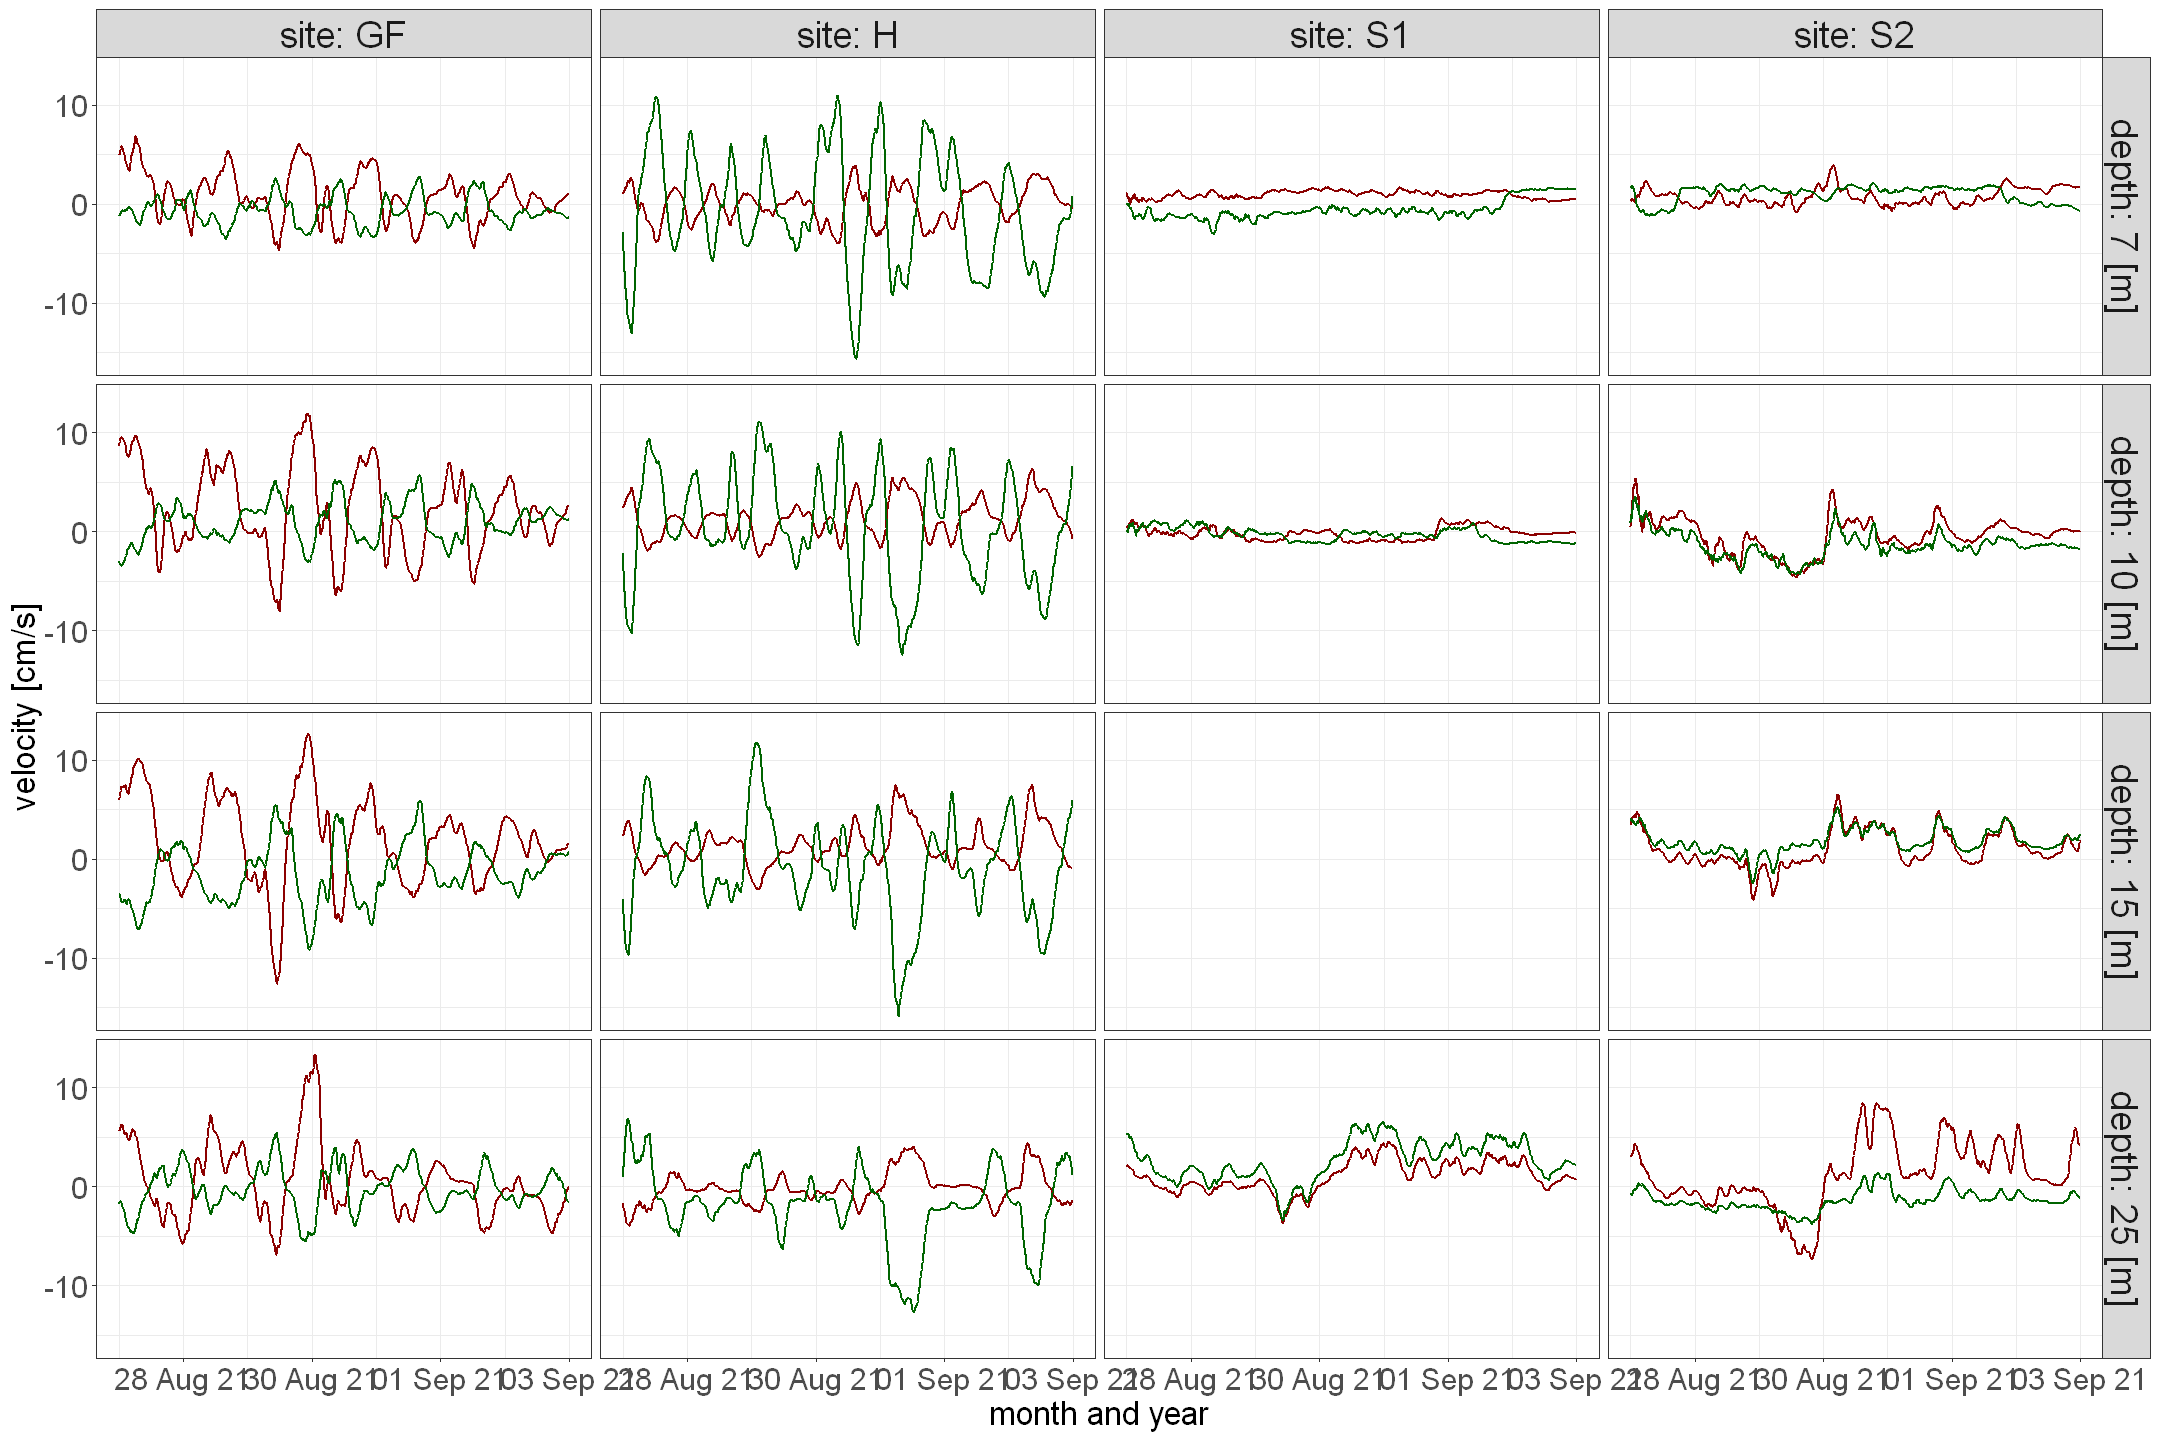

In [10]:
options(repr.plot.width=18, repr.plot.height=12)


ggplot(df.v.trends %>% filter(w.yr.factor==wk),aes(x=date_time)) +
geom_line(aes(y=velocityN.trend),color="darkred",linewidth=0.7)+
geom_line(aes(y=velocityE.trend),color="darkgreen",linewidth=0.7)+
scale_x_datetime(date_labels = "%d %b %y") +
 
xlab("month and year") + ylab("velocity [cm/s]") + 
facet_grid(depth~site,labeller = label_both) + 
theme(  axis.title.x = element_text(size = 20),
        axis.text.x = element_text(size=18),
        axis.title.y = element_text(size = 20),
        axis.text.y = element_text(size = 18),           
         strip.text = element_text(size = 22),
        legend.position="bottom",
        legend.key.size = unit(1, 'cm'),
        legend.title = element_text(size=22), 
        legend.text = element_text(size=20) ) 